# Analyze Expt 3.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import seaborn as sns
import SD_functions as SDF
import random

pi=np.pi
xx = np.linspace(-pi,pi,180)
n_bns=32
bns = np.linspace(-pi,pi,n_bns)
bns[0] -=1E-6
bns[-1] +=1E-6
d_bns = np.linspace(-180,180,n_bns)
overlap = 3
r2d,d2r = 180/pi,pi/180
pm = np.array((-1,1))

cols = sns.color_palette('Paired',4)
def sem(x): return np.std(x)/np.sqrt(len(x))

import statsmodels.formula.api as smf

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def sav_fig(nam):
    root = './Figures_v1/'
    plt.savefig(root + nam +'.svg',dpi=1200)

plt.rcParams.update({'font.size': 14
                    })

In [9]:
data = pd.read_parquet('data/data_processed_expt3_clean.parquet')

In [32]:
S = data
overlap = 3

cols_keep = ['compass','trial','correct','resp','probe_offset','drop_trials','stim','subj','delay']
def get_this_S(): # reliant on global variables
    _this_S = S.loc[:,cols_keep].copy().reset_index(drop=True) # which variables being used?
    if DO_SHUFFLE: _this_S = _this_S.reindex(np.random.permutation(_this_S.index))
    _this_S['d_ori'] = SDF.get_nb(nb,S.stim.values)
    _this_S['drop_prev'] = SDF.get_nb(nb,S.drop_trials.values,0)
    _this_S['no_drop']   = (S.drop_trials.values==0)#&(drop_prev==0) # not true drop on prev trial
    _this_S['compass_prev'] = SDF.get_nb(nb,S.compass.values,0)
    _this_S['d_dummy'] = SDF.wrapRad(SDF.get_nb(nb,S.dummy_lab_angle.values,0)-S.stim.values)
    return _this_S



In [11]:
print('n subj',S.subj.nunique())
print('n trial', len(S))
trial_cnts = S.groupby(['subj','fback']).resp.size().reset_index()

trial_cnts_tbl = trial_cnts.groupby('fback').resp.apply(lambda x: {'min':min(x),'max':max(x),'mean':np.mean(x),'SD':np.std(x),'SEM':np.std(x)/np.sqrt(len(x))})#.reset_index().set_index('task')
print(trial_cnts_tbl)

n subj 24
n trial 25248
fback      
1      min      480.000000
       max     1632.000000
       mean    1052.000000
       SD       383.478813
       SEM       78.277285
Name: resp, dtype: float64


In [12]:
nb=-1
this_S = get_this_S()
Su = this_S.query('drop_trials==0 & resp.notnull()',engine='python')
vals = tuple(Su.loc[:,['d_ori','resp']].values.T)

In [13]:
# functions for getting sliding avg of bias
p0_slide = (4,0)
def fit_this(these_ind):
    vals = vals_4[:,these_ind]
    stim_package = (vals[3],vals[4],p_stim_pool)
    arg = ((vals[1], stim_package),vals[2])
    this_fit = scipy.optimize.minimize(loss_fun_slide,p0_slide,args=arg,bounds=bnds_slide)
    return this_fit.x

def do_bining_fit(bns,overlap,grouping_var):

    n_bns=len(bns)
    grouper = np.zeros(len(bns))

    out = np.zeros((len(bns),2))*np.nan
    for i in range(n_bns):
        if i<overlap:
            these_ind = (grouping_var<=bns[i+overlap]) | (grouping_var>=bns[i-overlap])
        elif i>(n_bns-overlap-1):
            these_ind = (grouping_var>=bns[i-overlap]) | (grouping_var<=bns[i+overlap-n_bns])
        else:
            these_ind = (grouping_var>=bns[i-overlap])&(grouping_var<=bns[i+overlap]) # need to figure out 
        if ~np.any(these_ind) or (np.sum(these_ind)<min_n):
            continue
        out[i] = fit_this(these_ind)
    return out

# Define models

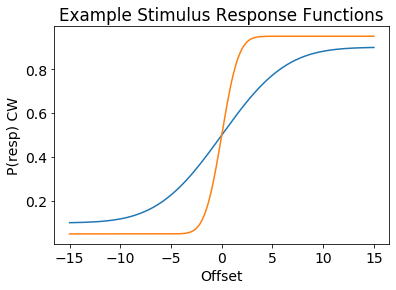

In [14]:
def softplus(x): return np.log(1 + np.exp(x))
def inv_softplus(x): return np.log(np.exp(x) - 1)

GUESS_RATE = 0.1
link_fun = softplus

def gauss_cdf(p,x):
    mu = 0
    w = link_fun(p[0])
    if len(p)>=2:
        guess_rate = p[1]
    else:
        guess_rate = GUESS_RATE 
        
    f = scipy.stats.norm(mu,w).cdf
    p_cdf = f(x)
    out = (1-guess_rate)*p_cdf + guess_rate/2
    return out

def log_loss(y,y_hat):
    loss = y*y_hat + (1-y_hat)*(1-y)
    return -np.sum(np.log(loss))

from scipy.special.cython_special import iv
Bessel0 = lambda x: iv(0,x)
def d_vm(w,x):
    return w*np.sin(x)*np.exp(w*np.cos(x))/(Bessel0(float(w)))

def Sd_vm(p,x): # scaled von mises -> adding link fun to keep w positive
    a,w=p
    w = link_fun(w)
    unscaled = d_vm(w,x)
    peak_val = 2*np.arctan(np.sqrt(np.sqrt(4*w**2+1)-2*w))
    denom = d_vm(w,peak_val)
    return a*unscaled/denom

def stim_bias_percept(p,stim,d_probe):
    w = link_fun(p[0])
    mu = SDF.many_sine_cos_v2(p[1:],stim)
    f = scipy.stats.norm(mu,w).cdf
    p_cdf = f(d_probe)
    guess_rate= GUESS_RATE
    out = (1-guess_rate)*p_cdf + guess_rate/2
    return out

def bias_percept(p,d_probe,stim_package):
    stim, compass, p_stim = stim_package
    w = link_fun(p[0])
    mu = p[1]
    guess_rate= GUESS_RATE
    mu_card = SDF.many_sine_cos_v2(p_stim[0],stim)*(compass==0) + SDF.many_sine_cos_v2(p_stim[1],stim)*(compass==1)
    f = scipy.stats.norm(mu+mu_card,w).cdf
    p_cdf = f(d_probe)
    out = (1-guess_rate)*p_cdf + guess_rate/2
    return out


def vm_percept(p,d_ori,d_probe):
    w = link_fun(p[0]) 
    p_vm = (p[1],p[2])
    guess_rate= GUESS_RATE
    
    mu = Sd_vm(p_vm,d_ori)
    
    f = scipy.stats.norm(mu,w).cdf
    p_cdf = f(d_probe)

    out = (1-guess_rate)*p_cdf + guess_rate/2
    return out

def vm_percept_bias(p,d_ori,d_probe):
    crf_w, sd_amp, sd_w, bias = p
    w = link_fun(p[0]) 
    p_vm = (p[1],p[2])
    mu = Sd_vm(p_vm,d_ori) + p[3]
    
    f = scipy.stats.norm(mu,w).cdf
    p_cdf = f(d_probe) # just distance so shouldnt need to worry about wrapping here?

    guess_rate= GUESS_RATE
    out = (1-guess_rate)*p_cdf + guess_rate/2
    return out

def vm_percept_cardinal_bias_correction(p,d_ori,d_probe,stim_package): 
    stim, compass, p_stim = stim_package
    
    p_vm = (p[0],p[1])
    w = link_fun(p[2]) 
    if len(p)>3:
        guess_rate = p[3]
    else:
        guess_rate= GUESS_RATE
    
    mu_sd = Sd_vm(p_vm,d_ori)
    mu_card = SDF.many_sine_cos_v2(p_stim[0],stim)*(compass==0) + SDF.many_sine_cos_v2(p_stim[1],stim)*(compass==1)
    mu = mu_sd + mu_card
    
    f = scipy.stats.norm(mu ,w).cdf
    p_cdf = f(d_probe)

    out = (1-guess_rate)*p_cdf + guess_rate/2
    return out
    

def loss_fun_meta(fun):
    def loss_fun(p,x,y):
        return log_loss(fun(p,x),y)
    return loss_fun

def loss_fun_meta_mult(fun):
    def loss_fun(p,x,y):
        y_hat = fun(p,*x)
        return log_loss(y_hat,y)
    return loss_fun


xx = np.linspace(-15,15,200)
p = (5,.2)
plt.plot(xx,gauss_cdf(p,xx))
p = (1,.1)
plt.plot(xx,gauss_cdf(p,xx))
plt.title('Example Stimulus Response Functions')
plt.xlabel('Offset')
plt.ylabel('P(resp) CW')
plt.show()


# fit stimulus response function (general)

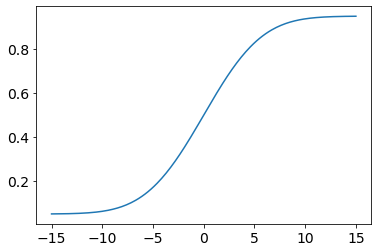

In [15]:
vals = tuple(Su.loc[:,['probe_offset','resp']].values.T)
p0 = (0)
this_loss = loss_fun_meta(gauss_cdf)
out = scipy.optimize.minimize(this_loss,p0,args=vals)

plt.plot(xx,gauss_cdf(out.x,xx))
plt.show()

# Fit doVM to raw responses

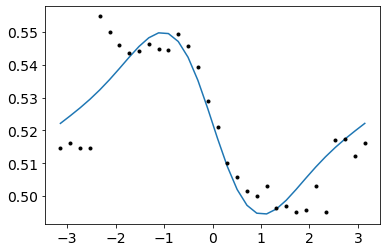

In [16]:
vals_1 = list(Su.loc[:,['d_ori','resp']].values.T.copy())
loss_fun_vm = SDF.rss_fun_bias(Sd_vm)
p0 = (0,0,0)

out = scipy.optimize.minimize(loss_fun_vm,p0,tuple(vals_1))
emp_bias_sd = SDF.do_bining(bns,overlap,*vals_1,want_var='mean')

plt.plot(bns,Sd_vm(out.x[:-1],bns)+out.x[-1])
plt.plot(bns,emp_bias_sd,'k.')
plt.show()

# Fit Fourier functions to stim bias

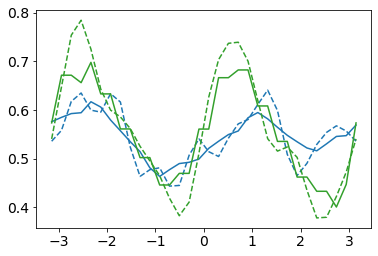

In [17]:
# view response bias cardinal
bias_fun = SDF.many_sine_cos_v2 # explore other options here
loss_fun = SDF.rss_fun(bias_fun)
x0 = (0,)*16

for comp in (0,1):
    vals_2 = tuple(S.query('~resp.isnull() & compass==@comp',engine='python').loc[:,['stim','resp']].values.T.copy())
    
    foo = SDF.do_bining(bns,overlap,*vals_2,want_var='mean')
    this_fit = scipy.optimize.minimize(loss_fun,x0,args=vals_2)
    
    plt.plot(bns,foo,color=cols[comp*2+1])
    plt.plot(bns,bias_fun(this_fit.x,bns),linestyle='--',color=cols[comp*2+1])

# Fit joint doVM and response function

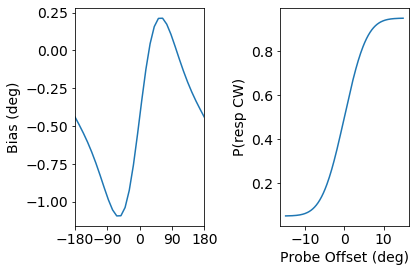

In [18]:
this_loss_bias = loss_fun_meta_mult(vm_percept_bias) # stim response fun, vm amp, vm width
p0 = (0,0,0,-1)

vals_3 = list(Su.loc[:,['d_ori','probe_offset','resp']].values.T.copy())
arg = ((vals_3[0],vals_3[1]),vals_3[2])

this_fit_bias = scipy.optimize.minimize(this_loss_bias,p0,args=arg)
coef = this_fit_bias.x

plt.subplot(1,2,1)
plt.plot(bns*r2d,Sd_vm(coef[1:3],bns)+coef[3])
SDF.d_plot()
plt.ylabel('Bias (deg)')
plt.subplot(1,2,2)
plt.plot(xx,gauss_cdf(coef[:1],xx))
plt.xlabel('Probe Offset (deg)')
plt.ylabel('P(resp CW)')
plt.tight_layout()
plt.show()


# Estimate card bias in degrees

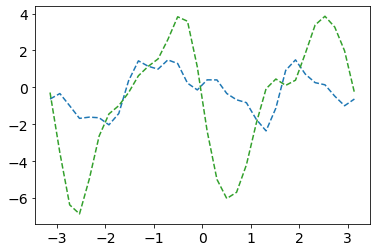

In [19]:
loss_fun = loss_fun_meta_mult(stim_bias_percept)
x0 = (8,)+(0,)*16
p_stim_pool = []
for comp in (0,1):
    vals_2 = tuple(Su.query('~resp.isnull() & compass==@comp',engine='python').loc[:,['stim','probe_offset','resp']].values.T.copy())
    args = ((vals_2[0],vals_2[1]), vals_2[2])

    this_fit = scipy.optimize.minimize(loss_fun,x0,args=args)

    plt.plot(bns,bias_fun(this_fit.x[1:],bns),linestyle='--',color=cols[comp*2+1])
    p_stim_pool.append(this_fit.x[1:])

# And use those fit corrections when estimating serial dependence

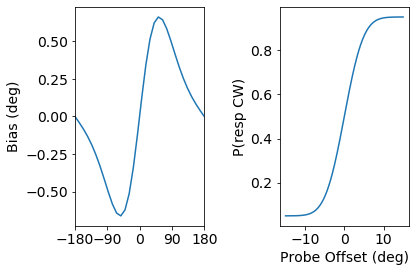

In [20]:
loss_fun_complete = loss_fun_meta_mult(vm_percept_cardinal_bias_correction)

vals_4 = list(Su.loc[:,['d_ori','probe_offset','resp','stim','compass']].values.T.copy())

stim_package = (vals_4[3],vals_4[4],p_stim_pool)
arg = ((vals_4[0],vals_4[1], stim_package),vals_4[2])

p0 = (0,0,0)

this_fit_complete = scipy.optimize.minimize(loss_fun_complete,p0,args=arg)
coef = this_fit_complete.x

plt.subplot(1,2,1)
plt.plot(bns*r2d,Sd_vm(coef[:2],bns))
SDF.d_plot()
plt.ylabel('Bias (deg)')
plt.subplot(1,2,2)
plt.plot(xx,gauss_cdf(coef[2:],xx))
plt.xlabel('Probe Offset (deg)')
plt.ylabel('P(resp CW)')
plt.tight_layout()
plt.show()

# Do "complete" fitting for different data subsets

In [21]:
loss_fun_complete = loss_fun_meta_mult(vm_percept_cardinal_bias_correction)
p0 = (0,0,0)

coefs = []
query_0 = 'compass==@comp & compass_prev==@comp_prev'# & delay==5'
for comp in (0,1):
    _coefs=[]
    for comp_prev in (0,1):
        vals_4 = list(Su.query(query_0).loc[:,['d_ori','probe_offset','resp','stim','compass']].values.T.copy())

        stim_package = (vals_4[3],vals_4[4],p_stim_pool)
        arg = ((vals_4[0],vals_4[1], stim_package),vals_4[2])

        this_fit_complete = scipy.optimize.minimize(loss_fun_complete,p0,args=arg)

        coef = this_fit_complete.x
        _coefs.append(coef)
    coefs.append(_coefs)

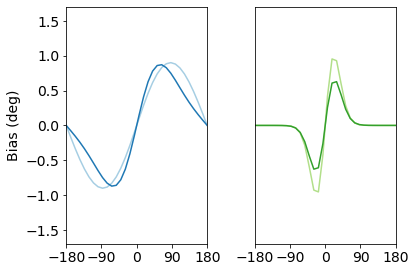

In [22]:
yl = pm*1.7
for comp in (0,1):
    plt.subplot(1,2,comp+1)
    for comp_prev in (0,1):
        coef = coefs[comp][comp_prev]
        plt.plot(bns*r2d,Sd_vm(coef[:2],bns),color=cols[comp*2+comp_prev])
    SDF.d_plot()
    plt.ylim(yl)
    if comp==0:
        plt.ylabel('Bias (deg)')
    else:
        plt.yticks([])
plt.tight_layout()
plt.show()    

In [108]:
subjs = list(S.subj.unique())
n_shuf = 100
subjs_use = subjs +['POOL',] + ['POOL_RAND',]*n_shuf

subjs_use = ['POOL_RAND',]*n_shuf

loss_fun_complete = loss_fun_meta_mult(vm_percept_cardinal_bias_correction)
p0 = (0,inv_softplus(1),inv_softplus(5))#,.2)
bnds_vm_full = ((-15,15),(inv_softplus(0.1),inv_softplus(15)),(inv_softplus(0.1),15))#,(0.01,0.2))

query_0 = 'subj==@subj & compass==@ci &  drop_trials==0 & resp.notnull()'
query_1 = 'subj==@subj & compass!=@comp & compass_prev!=@comp_prev & delay!=@delay & drop_prev==@dp'
query_0_pool = 'compass==@ci &  drop_trials==0 & resp.notnull()'
query_1_pool = 'compass!=@comp & compass_prev!=@comp_prev & delay!=@delay & drop_prev==@dp'

p_stim_use = p_stim_pool

nb_want =  [*np.arange(-1,-7,-1),(-5,-1)]
# nb_want = np.arange(-1,-2,-1)

nb=-1
this_S = get_this_S()
Su = this_S.query('drop_trials==0 & resp.notnull()',engine='python')
dp=0

bnds_slide = ((0,15),((-5,5)))
min_n = 15
loss_fun_slide = loss_fun_meta_mult(bias_percept)

# fits_all = pd.DataFrame()
    
    
for si, subj in enumerate(subjs_use):
    print(f'{si+1}/{len(subjs_use)}',end=', ')

    is_pool = subj[:4]=='POOL'
    if is_pool:
        query_now,query_hist = query_0_pool,query_1_pool
        DO_SHUFFLE = subj[5:]=='RAND'
    else:
        query_now,query_hist = query_0,query_1
        DO_SHUFFLE=False

    for ci,comp in enumerate(('dot','comp')):
        if DO_SHUFFLE:
            continue
        this_d = S.query(query_now,engine='python')
        vals_4 = this_d.loc[:,['dummy_stim','probe_offset','resp','stim','compass']].values.copy().T
        
        d_dummy = SDF.wrapRad(vals_4[0]-vals_4[3]) # dummy-stim
        stim_package = (vals_4[3],vals_4[4],p_stim_use)
        arg_dummy = ((d_dummy,vals_4[1], stim_package),vals_4[2])
        
        # d-dummy, probe_offset, stim_package, resp
        this_fit_dummy = scipy.optimize.minimize(loss_fun_complete,p0,args=arg_dummy,bounds=bnds_vm_full)
        coef_dummy = this_fit_dummy.x
                        

        slide_bias = do_bining_fit(bns,overlap,d_dummy,).T
        this_fit = {'subj':subj,'nb':0,'nb_str':'0',
                   'compass':comp,
                    'compass_prev':'both','delay':'both',
                    'drop_prev':np.nan,
                    'amp_dummy':coef_dummy[0],'w_dummy':coef_dummy[1],'sigma_dummy':coef_dummy[2],
                    'n_trials':len(d_dummy),
                    'this_fit':Sd_vm(coef_dummy[:2],bns),
                    'slide_var':slide_bias[0],'slide_bias':slide_bias[1],'pool':is_pool,'shuffle':DO_SHUFFLE}
        fits_all = fits_all.append(this_fit,ignore_index=True)
        
    for nbi,_nb in enumerate(nb_want):
        
        if (type(_nb) is tuple) : # expect nb_want entries to be ranges...
            __this_S = []
            for nb in np.arange(*_nb):
                _this_S = get_this_S()
                __this_S.append(_this_S)
            this_S = pd.concat(__this_S).reset_index()
            nb = np.min(nb)
            nb_str = f'{_nb[0]}-{_nb[1]}'
        else:
            nb = _nb
            nb_str = str(nb)
            this_S = get_this_S()
            
        Su = this_S.query('drop_trials==0 & resp.notnull()',engine='python')
            
        for ci,comp in enumerate((1,0)):
            for cpi,comp_prev in enumerate((1,0,2)):
                for dp in range(2):
                    for di,delay in enumerate((5,2,10)):
                        if (di<2) and (comp_prev!=2):
                            continue
                        vals_4 = (Su.query(query_hist).loc[:,['d_ori','probe_offset','resp','stim','compass','d_dummy']].values.T.copy())
#                         vals_4 = list(Su.query(query_1).loc[:,['d_ori','probe_offset','resp','stim','compass','d_dummy']].values.T.copy())

                        stim_package = (vals_4[3],vals_4[4],p_stim_use)

                        d_ori_use = vals_4[0]
                        d_dummy_use = vals_4[5]

                        arg = ((d_ori_use,vals_4[1], stim_package),vals_4[2])
                        arg_dummy = ((d_dummy_use,vals_4[1], stim_package),vals_4[2])

                        this_fit_complete = scipy.optimize.minimize(loss_fun_complete,p0,args=arg,bounds=bnds_vm_full)
                        coef = this_fit_complete.x

                        this_fit_dummy = scipy.optimize.minimize(loss_fun_complete,p0,args=arg_dummy,bounds=bnds_vm_full)
                        coef_dummy = this_fit_dummy.x
                        
                        #- get sliding avg.
                        # save time -- only for general conditions
                        if (delay!=10) or (dp==1):
                            slide_bias = [np.nan,np.nan]
                        else:
                            slide_bias = do_bining_fit(bns,overlap,d_ori_use,).T

                        this_fit = {'subj':subj,'nb':nb,'nb_str':nb_str,
                                    'compass':['dot','comp','both'][ci],
                                   'compass_prev':['dot','comp','both'][cpi],'delay':['short','long','both'][di],
                                    'drop_prev':dp,
                                   'ampVM':coef[0],'wVM':coef[1],'sigma':coef[2],
                                   'amp_dummy':coef_dummy[0],'w_dummy':coef_dummy[1],'sigma_dummy':coef_dummy[2],
                                    'n_trials':len(d_ori_use),
                                   'this_fit':Sd_vm(coef[:2],bns),
                                   'slide_var':slide_bias[0],'slide_bias':slide_bias[1],'pool':is_pool,'shuffle':DO_SHUFFLE}
                        fits_all = fits_all.append(this_fit,ignore_index=True)
fits_all['condition'] = fits_all.compass_prev.values + '->' + fits_all.compass.values
fits_all['task'] = 'expt3'
DO_SHUFFLE=False

1/40, 2/40, 3/40, 4/40, 5/40, 6/40, 7/40, 8/40, 9/40, 10/40, 11/40, 12/40, 13/40, 14/40, 15/40, 16/40, 17/40, 18/40, 19/40, 20/40, 21/40, 22/40, 23/40, 24/40, 25/40, 26/40, 27/40, 28/40, 29/40, 30/40, 31/40, 32/40, 33/40, 34/40, 35/40, 36/40, 37/40, 38/40, 39/40, 40/40, 

In [109]:
# save out for export

fits_all_save = fits_all.query('delay=="both"')
fits_all_save.to_parquet('data/fits_expt3.parquet')

In [112]:
# fits_all_delay = fits_all.query('delay!="both"')
# fits_all_delay.to_parquet('data/fits_expt3_delay.parquet')